In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

path_name = "C:\\Users\\friso\\BEP\\Raw_data\\final4um\\Data\\"

folder_names = [item for item in os.listdir(path_name) if os.path.isdir(os.path.join(path_name, item))] # Make a list of all folders in this path name
experiment_numbers = [int(name.split("_")[-1]) for name in folder_names]                                # Make a list of all experiment numbers _x, last part of each experiment name
folder_names = [name for _, name in sorted(zip(experiment_numbers, folder_names))]                      # Sort folder_names based on experiment numbers in ascending order

data_segments = {}
sweep_categories = 15 # total number of different experiments
sweep_repeats    = 20 # total number of experiments per category

time_step = 21
global_time = time_step / 42.0
custom_labels = [r"Superficial zone" "\n" r"$\epsilon_{ECM} = -15\% $", r"Middle zone" "\n" r"$\epsilon_{ECM} = -7.5\% $", r"Deep zone" "\n" r"$\epsilon_{ECM} = -2.5\% $"]

for i in range(sweep_categories):       # Total amount of indiviual sweep lines
    start_idx = i * sweep_repeats     
    end_idx = (i + 1) * sweep_repeats
    data_key = f"data_{chr(97 + i)}"  # 'a', 'b', 'c', .... # from a to z based on the category
    data_segments[data_key] = folder_names[start_idx:end_idx]

total_data = {} # dictionary with all data, keys are the distinguishing parameters of each category
# with cell
total_data['Middle zone, false PCM']         = ['False']+ data_segments["data_a"] # the functions need a PCM boolean as first parameter
total_data['Middle zone, parallel PCM']      = ['True'] + data_segments["data_b"]
total_data['Middle zone, isotropic PCM']     = ['True'] + data_segments["data_c"]
total_data['Middle zone, normal PCM']        = ['True'] + data_segments["data_d"]
total_data['Super zone, false PCM']          = ['False']+ data_segments["data_e"]
total_data['Super zone, parallel PCM']       = ['True'] + data_segments["data_f"]
total_data['Super zone, isotropic PCM']      = ['True'] + data_segments["data_g"]
total_data['Super zone, normal PCM']         = ['True'] + data_segments["data_h"]
total_data['Deep zone, false PCM']           = ['False']+ data_segments["data_i"]
total_data['Deep zone, parallel PCM']        = ['True'] + data_segments["data_j"]
total_data['Deep zone, isotropic PCM']       = ['True'] + data_segments["data_k"]
total_data['Deep zone, normal PCM']          = ['True'] + data_segments["data_l"]


In [42]:
def calc_cell_strain(experiment, PCM, time_step = -1): # take the last timestep by default
    """ 
    Inputs:
        experiment: folder string, name of an experiment folder containing 'Chondrons_N_E_idx' and 'Edge_orientation' files. needs a global pathname variable
        PCM:        boolean, true for experiments with PCM
        time_step:  integer, the time step that should be calculated, defaults to the last timestep of the recorder data

    Output: 
        list: each element is the maximal deformation strain of a chondrocyte, can easily be expaneded to inlcude chondrocyte positions or any other parameter
    """

    bool_PCM = PCM
    plot_data = []

    filename_chondrons   = (path_name + experiment + "\\Chondrons_N_E_idx").replace('\\', '/') # filename from windows path
    filename_orientation = (path_name + experiment + "\\Edge_orientation").replace('\\', '/') # filename from windows path
    filename_stress_strain = (path_name + experiment + "\\Stress_strain").replace('\\', '/') # filename from windows path

    stress_df = pd.read_csv(filename_stress_strain)
    stress_df = stress_df.fillna(0.0)     # Replace all -nan(ind) values with 0.0000
    stress_df.astype('Float32')    
    # skip if the simulation crashed
    if stress_df['Stress'].iloc[time_step] == 0.0:
        return None

    # load and edge orientation data----------------------------------------------------------------------------------------------
    pre_df_edge_o = pd.read_csv(filename_orientation, on_bad_lines='skip')
    pre_df_edge_o = pre_df_edge_o.fillna(0.0)                        # replace all -nan(ind) values with 0.0000 to prevent type errors
    pre_df_edge_o.astype('Float32')                                                        # cast the float strings to float32

    # load and create chondron index dictionary-------------------------------------------------------------------------------
    pre_df = pd.read_csv(filename_chondrons, index_col=0, header=None).T # Read data and transpose chondron row csv to column csv

    chondrons_dict = {}
    for series_name, series in pre_df.items():
        chon_name = 'chon_dict/' + str(series_name)
        chond_dict = {}
        if not bool_PCM:
            [chond_dict.setdefault(x, []) for x in ['memb_nodes', 'cyto_edges', 'memb_edges', 'memb_ECM']] # these are all categories wihtout PCM
        else:
            [chond_dict.setdefault(x, []) for x in ['memb_nodes', 'cyto_edges', 'memb_edges', 'PCM_nodes', 'PCM_edges', 'PCM_memb', 'PCM_ECM']]   

        chondrons_dict[chon_name] = chond_dict
        count = 0

        for a in range(1, len(series)):        
            if series[a] == 0: # padded 0's, discard the rest of the series
                break
            if not bool_PCM:
                if count == 0:
                    chond_dict['memb_nodes'].append(np.abs(series[a]))
                if count == 1:
                     chond_dict['cyto_edges'].append(np.abs(series[a]))
                if count == 2:
                    chond_dict['memb_edges'].append(np.abs(series[a]))
                if count == 3:
                    chond_dict['memb_ECM'].append(np.abs(series[a]))

                b = a + 1
                if np.sign(series[a]) != np.sign(series[b]):
                    count += 1    # sign change detected, increase count so that next integers are assigned to the next key
            else:
                if count == 0:
                    chond_dict['memb_nodes'].append(np.abs(series[a]))
                if count == 1:
                     chond_dict['cyto_edges'].append(np.abs(series[a]))
                if count == 2:
                    chond_dict['memb_edges'].append(np.abs(series[a]))
                if count == 3:
                    chond_dict['PCM_nodes'].append(np.abs(series[a]))
                if count == 4:
                    chond_dict['PCM_edges'].append(np.abs(series[a]))
                if count == 5:
                    chond_dict['PCM_memb'].append(np.abs(series[a]))
                if count == 6:
                    chond_dict['PCM_ECM'].append(np.abs(series[a]))
                b = a + 1
                if np.sign(series[a]) != np.sign(series[b]):
                     count += 1


    # plot chondrocyte strain-------------------------------------------------------------------------------------------------------
    edge_o = pd.DataFrame(pre_df_edge_o.groupby('Time')).iloc[time_step, 1] 

    chond_strain = {} # the strain dictionary of this experiment
    [chond_strain.setdefault(x, []) for x in chondrons_dict]
        
    for chondron in chondrons_dict:

        cyto_edges = chondrons_dict[chondron]['cyto_edges'] # all the cytoplasm edges of this chondron

        filtered_edges = edge_o[edge_o['Edge_idx'].isin(cyto_edges)] # filter rows that are not cytplasm edges to reduce double for loop
        for indA in filtered_edges.index:
            dist = 2.0
            closestA = -1 #initialize to false index to indicate key error
            closestB = -1 

        
            thetaA = filtered_edges['Theta'][indA]
            phiA = filtered_edges['Phi'][indA]

            for indB in filtered_edges.index:

                if indB == indA:
                    continue
                thetaB = np.pi + filtered_edges['Theta'][indB] % 2 * np.pi #transfrom
                phiB = np.pi - filtered_edges['Phi'][indB] # transform

                temp_dist = ((thetaA - thetaB) / (2.0 * np.pi))**2 + ((phiA - phiB) / (np.pi))**2
                if temp_dist < dist:
                    dist = temp_dist
                    closestA = indA
                    closestB = indB

            if closestA == -1 or closestB == -1:
                break
                
            chond_strain[chondron].append(filtered_edges.loc[closestA, 'Edge_strain'] / 2.0 + filtered_edges.loc[closestB, 'Edge_strain'] / 2.0) # append this chondron strain
        
        chond_strain[chondron] = np.min(chond_strain[chondron])

    # plotting strain dictionary
    for chondron in chond_strain:
        plot_data.append(chond_strain[chondron])

                
    return plot_data
                
def calc_membrane_strain(experiment, PCM, time_step = -1): # take the last timestep by default
    bool_PCM = PCM
    plot_data = []

    filename_chondrons   = (path_name + experiment + "\\Chondrons_N_E_idx").replace('\\', '/') # filename from windows path
    filename_orientation = (path_name + experiment + "\\Edge_orientation").replace('\\', '/') # filename from windows path
    filename_stress_strain = (path_name + experiment + "\\Stress_strain").replace('\\', '/') # filename from windows path
    # load and edge orientation data----------------------------------------------------------------------------------------------
    pre_df_edge_o = pd.read_csv(filename_orientation, on_bad_lines='skip')
    pre_df_edge_o = pre_df_edge_o.fillna(0.0)                        # replace all -nan(ind) values with 0.0000 to prevent type errors
    pre_df_edge_o.astype('Float32')                                                        # cast the float strings to float32

    # load and create chondron index dictionary-------------------------------------------------------------------------------
    pre_df = pd.read_csv(filename_chondrons, index_col=0, header=None).T # Read data and transpose chondron row csv to column csv

    stress_df = pd.read_csv(filename_stress_strain)
    stress_df = stress_df.fillna(0.0)      # Replace all -nan(ind) values with 0.0000
    stress_df.astype('Float32')   
    # skip if the simulation crashed
    if stress_df['Stress'].iloc[time_step] == 0.0:
        return None
    
    chondrons_dict = {} #initialize chondron dictionary
    for series_name, series in pre_df.items():
        chon_name = 'chon_dict/' + str(series_name)
        chond_dict = {}
        if not bool_PCM:
            [chond_dict.setdefault(x, []) for x in ['memb_nodes', 'cyto_edges', 'memb_edges', 'memb_ECM']]
        else:
            [chond_dict.setdefault(x, []) for x in ['memb_nodes', 'cyto_edges', 'memb_edges', 'PCM_nodes', 'PCM_edges', 'PCM_memb', 'PCM_ECM']]   

        chondrons_dict[chon_name] = chond_dict

        count = 0 # count is the object identifier, is increased by one when a sign change is detected

        for a in range(1, len(series)):        
            if series[a] == 0: # padded 0's, discard the rest of the series
                break
            if not bool_PCM:
                if count == 0:
                    chond_dict['memb_nodes'].append(np.abs(series[a]))
                if count == 1:
                     chond_dict['cyto_edges'].append(np.abs(series[a]))
                if count == 2:
                    chond_dict['memb_edges'].append(np.abs(series[a]))
                if count == 3:
                    chond_dict['memb_ECM'].append(np.abs(series[a]))

                b = a + 1
                if np.sign(series[a]) != np.sign(series[b]):
                    count += 1
            else:
                if count == 0:
                    chond_dict['memb_nodes'].append(np.abs(series[a]))
                if count == 1:
                     chond_dict['cyto_edges'].append(np.abs(series[a]))
                if count == 2:
                    chond_dict['memb_edges'].append(np.abs(series[a]))
                if count == 3:
                    chond_dict['PCM_nodes'].append(np.abs(series[a]))
                if count == 4:
                    chond_dict['PCM_edges'].append(np.abs(series[a]))
                if count == 5:
                    chond_dict['PCM_memb'].append(np.abs(series[a]))
                if count == 6:
                    chond_dict['PCM_ECM'].append(np.abs(series[a]))
                b = a + 1
                if np.sign(series[a]) != np.sign(series[b]):
                     count += 1


    # calculate membrane strain-------------------------------------------------------------------------------------------------------
    edge_o = pd.DataFrame(pre_df_edge_o.groupby('Time')).iloc[time_step, 1]  # change to max stress time location for peak dynamics

    membrane_strain_dict = {} # the strain dictionary of this experiment
    [membrane_strain_dict.setdefault(x, []) for x in chondrons_dict]
        
    for chondron in chondrons_dict: # loop over each chondrocyte edge to create an array with all membrane strains

        membrane_edges = chondrons_dict[chondron]['memb_edges'] # all the membrane edges of this chondron
        filtered_edges = edge_o[edge_o['Edge_idx'].isin(membrane_edges)] # filter rows that are not cytplasm edges to reduce for loop

        strain_array = []
        for edge in filtered_edges.index:
            strain_array.append(filtered_edges.loc[edge, 'Edge_strain'])

        membrane_strain_dict[chondron] = strain_array


    # turn dictionary to array 
    for chondron in membrane_strain_dict:
        plot_data.append(membrane_strain_dict[chondron])
     
    return list(plot_data) # return the array

def runs_get_data(experiments):
    #create an added dataframe of all experiments in the run
    df = pd.DataFrame()
    for idx, experiment in enumerate(experiments):
        filename = (path_name + experiment + "\\Stress_strain").replace('\\', '/')
        pre_df = pd.read_csv(filename)
        pre_df = pre_df.fillna(0)      # Replace all -nan(ind) values with 0.0000
        if idx == 0:
            df = pre_df.copy()  # Initialize the DataFrame
        else:
            df = pd.concat([df, pre_df], axis=0) # concataneta all columns

    # Compute means and standard deviations
    df_mean = df.groupby(['Time']).mean(numeric_only=True).reset_index() # group per time step and average within this group
    df_std = df.groupby(['Time']).std(numeric_only=True).reset_index() # find the standard deviation of each time step

    runs = pd.DataFrame(df.groupby('Time')).iloc[-1, 1]
    runs = runs['Stress']
    runs = sum(~np.isnan(runs))
    
    # Return mean, std, and the number of averaged runs
    return [df_mean, df_std, runs]


CELL STRAIN SECTION


In [26]:
cyt_data_dict = {}
for key in total_data:
    strain_array = []
    for experiment in total_data[key][1:]:
        this_strain = calc_cell_strain(experiment, total_data[key][0], time_step)
        if this_strain == None:
            continue
        strain_array.append(this_strain)
    cyt_data_dict[key] = strain_array

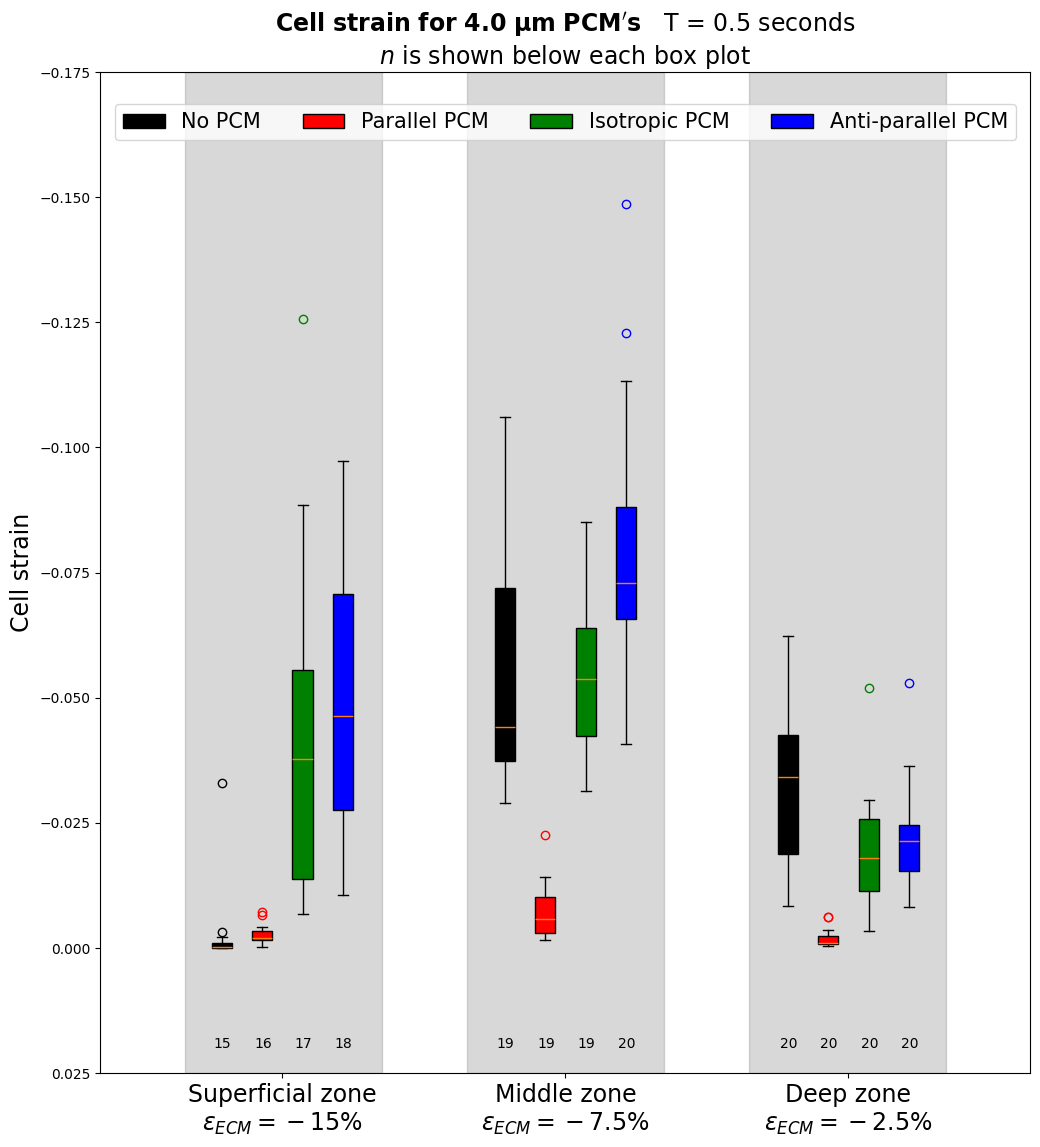

In [35]:
fig, ax = plt.subplots(figsize = (12, 13))
for key in cyt_data_dict:
    data = np.array(cyt_data_dict[key]).flatten()
    if 'Super' in key:
        if 'false' in key:
            c = 'black'
            bp1 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [3])
            ax.text(2.8, 0.02, str(len(data)))
        if 'parallel' in key:
            c = 'red'
            bp2 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [4])
            ax.text(3.8, 0.02, str(len(data)))
        if 'isotropic' in key:
            c = 'green'
            bp3 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [5])
            ax.text(4.8, 0.02, str(len(data)))
        if 'normal' in key:
            c = 'blue'
            bp4 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [6])
            ax.text(5.8, 0.02, str(len(data)))

    elif 'Middle' in key:
        if 'false' in key:
            c = 'black'
            bp5 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [10])
            ax.text(9.8, 0.02, str(len(data)))
        if 'parallel' in key:
            c = 'red'
            bp6 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [11])
            ax.text(10.8, 0.02, str(len(data)))
        if 'isotropic' in key:
            c = 'green'
            bp7 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [12])
            ax.text(11.8, 0.02, str(len(data)))
        if 'normal' in key:
            c = 'blue'
            bp8 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [13])
            ax.text(12.8, 0.02, str(len(data)))

    else:
        if 'false' in key:
            c = 'black'
            bp9 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [17])
            ax.text(16.8, 0.02, str(len(data)))
        if 'parallel' in key:
            c = 'red'
            bp10 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [18])
            ax.text(17.8, 0.02, str(len(data)))
        if 'isotropic' in key:
            c = 'green'
            bp11 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [19])
            ax.text(18.8, 0.02, str(len(data)))
        if 'normal' in key:
            c = 'blue'
            bp12 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [20])
            ax.text(19.8, 0.02, str(len(data)))



x = np.linspace(0, 23, 100)
ax.fill_between(x, 0, 1, where= (x >= 2) & (x <= 7), color='grey', alpha=0.3, transform=ax.get_xaxis_transform())
ax.fill_between(x, 0, 1, where= (x >= 9) & (x <= 14), color='grey', alpha=0.3, transform=ax.get_xaxis_transform())
ax.fill_between(x, 0, 1, where= (x >= 16) & (x <= 21), color='grey', alpha=0.3, transform=ax.get_xaxis_transform())

plt.xticks([4.5, 11.5, 18.5], custom_labels, size = 17)
ax.set_ylabel("Cell strain", size = 17)
ax.set_xlim(0, 23)
ax.set_ylim(ymin=-0.175, ymax=0.025)
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]], ['No PCM', 'Parallel PCM', "Isotropic PCM", "Anti-parallel PCM"], ncol = 4, loc='center', bbox_to_anchor=(0.5, 0.95), fontsize = 15)
ax.invert_yaxis()

plt.title(r"$\bf{Cell\ strain\ for\ 4.0\ \mu m\ PCM's\ \ \ } $" f"T = {np.round(global_time, 1)} seconds" "\n" r"$n$" " is shown below each box plot" , fontsize = 17)
plt.show()


MEMBRANE STRAIN SECTON

In [28]:
memb_data_dict = {}
for key in total_data:
    strain_array = []
    for experiment in total_data[key][1:]:
        this_strain_array = calc_membrane_strain(experiment, total_data[key][0], time_step)
        if this_strain_array == None:
            continue
        strain_array.append(this_strain_array)

    #strain_array = [x for x in strain_array if x > 0] # select positive values only
    strain_array = np.array(strain_array).flatten()
    memb_data_dict[key] = [x for x in strain_array if x > 0] # select positive strain values

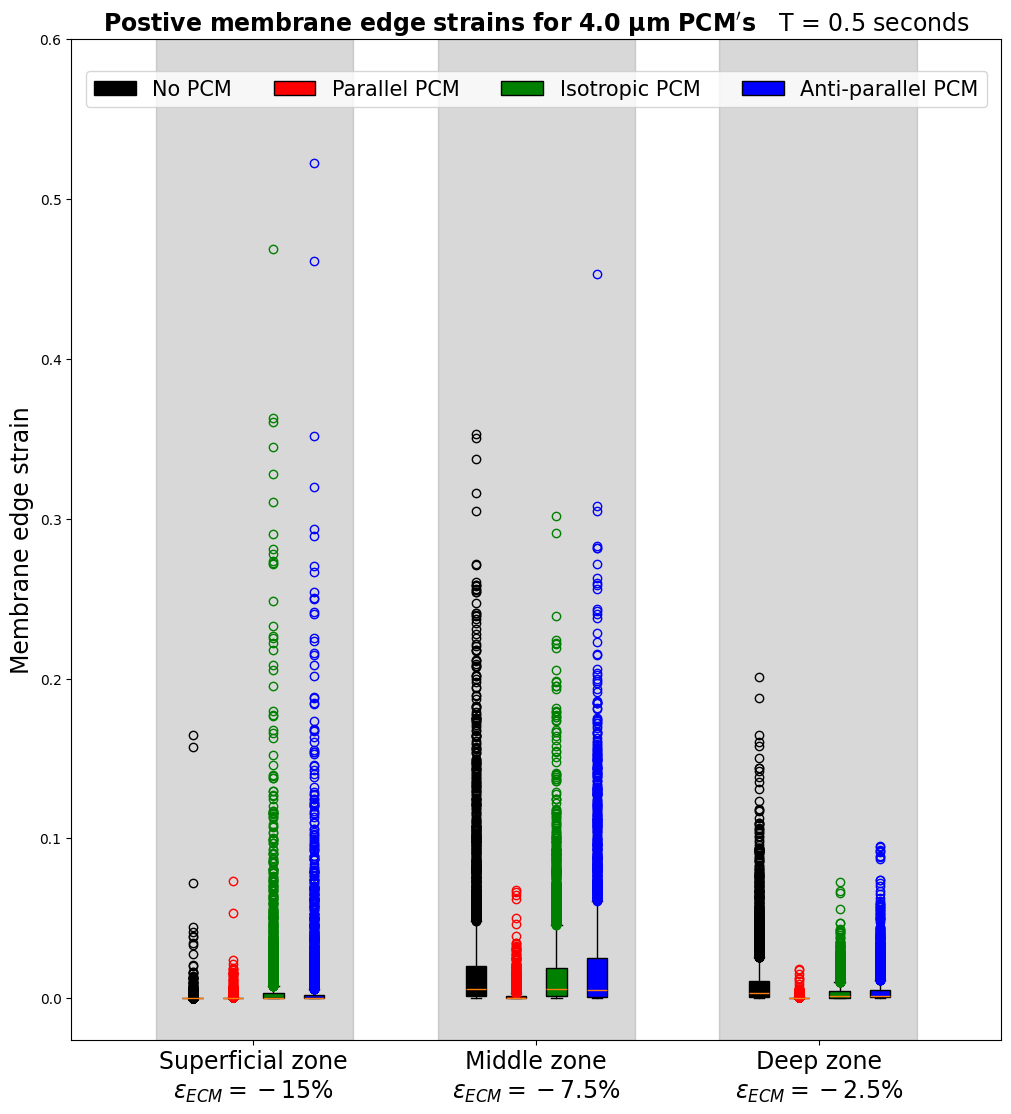

In [34]:
fig, ax = plt.subplots(figsize = (12, 13))
for key in memb_data_dict:
    data = np.array(memb_data_dict[key]).flatten()
    if 'Super' in key:
        if 'false' in key:
            c = 'black'
            bp1 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [3])
        if 'parallel' in key:
            c = 'red'
            bp2 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [4])
        if 'isotropic' in key:
            c = 'green'
            bp3 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [5])
        if 'normal' in key:
            c = 'blue'
            bp4 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [6])

    elif 'Middle' in key:
        if 'false' in key:
            c = 'black'
            bp5 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [10])
        if 'parallel' in key:
            c = 'red'
            bp6 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [11])
        if 'isotropic' in key:
            c = 'green'
            bp7 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [12])
        if 'normal' in key:
            c = 'blue'
            bp8 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [13])

    else:
        if 'false' in key:
            c = 'black'
            bp9 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [17])
        if 'parallel' in key:
            c = 'red'
            bp10 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [18])
        if 'isotropic' in key:
            c = 'green'
            bp11 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [19])
        if 'normal' in key:
            c = 'blue'
            bp12 = ax.boxplot(data, patch_artist=True, widths = 0.5, boxprops=dict(facecolor=c), flierprops=dict(color=c, markeredgecolor=c), positions = [20])



x = np.linspace(0, 23, 100)
ax.fill_between(x, 0, 1, where= (x >= 2)  & (x <= 7),  color='grey', alpha=0.3, transform=ax.get_xaxis_transform())
ax.fill_between(x, 0, 1, where= (x >= 9)  & (x <= 14), color='grey', alpha=0.3, transform=ax.get_xaxis_transform())
ax.fill_between(x, 0, 1, where= (x >= 16) & (x <= 21), color='grey', alpha=0.3, transform=ax.get_xaxis_transform())

plt.xticks([4.5, 11.5, 18.5], custom_labels, size = 17)
ax.set_ylabel("Membrane edge strain", size = 17)
ax.set_xlim(0, 23)
ax.set_ylim(ymax=0.6)
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]], ['No PCM', 'Parallel PCM', "Isotropic PCM", "Anti-parallel PCM"], ncol = 4, loc='center', bbox_to_anchor=(0.5, 0.95), fontsize = 15)
plt.title(r"$\bf{Postive\ membrane\ edge\ strains\ for\ 4.0\ \mu m\ PCM's\ \ \ } $" f"T = {np.round(global_time, 1)} seconds", fontsize = 17)

plt.show()

CONTROL NETWORKS SECTION

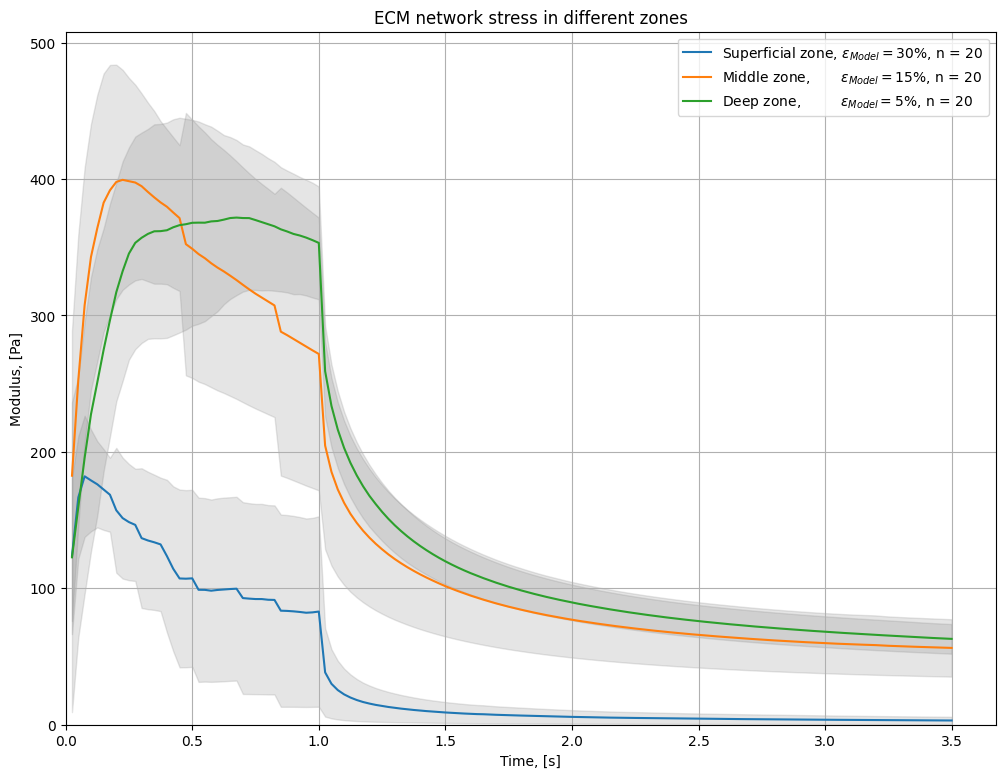

In [39]:
# control data
total_data['control_iso']                   = ['False'] + data_segments["data_m"]
total_data['control_anti']                  = ['False'] + data_segments["data_n"]
total_data['control_par']                   = ['False'] + data_segments["data_o"]

control_data_dict = {}
for key in ['control_par', 'control_iso', 'control_anti']:
    control_data_dict[key] = runs_get_data(total_data[key][1:])

fig, ax1 = plt.subplots(figsize=(12, 9)) 
for key in control_data_dict:
    df_mean = control_data_dict[key][0]
    df_std = control_data_dict[key][1]
    runs = control_data_dict[key][2]
    modulus = df_mean['Stress'] / df_mean['Strain'] 
    std = df_std['Stress'] / df_mean['Strain'] 
    if key == 'control_iso':
        key = 'Middle zone,       ' r"$\varepsilon_{Model} = 15\%$"
    if key == 'control_par':
        key = 'Superficial zone, ' r"$\varepsilon_{Model} = 30\%$"
    if key == 'control_anti':
        key = 'Deep zone,         ' r"$\varepsilon_{Model} = 5\%$"
    ax1.plot(df_mean['Time'], modulus, label = key + f", n = {runs}")
    ax1.fill_between(df_mean['Time'], [max(this, 0) for this in modulus-std],  modulus+std,  color = 'grey', alpha=0.2) 

plt.title(f'ECM network modulus in different ECM zones')
plt.legend()
plt.xlabel('Time, [s]')
plt.ylabel('Modulus, [Pa]')
ax1.set_ylim(ymin = 0)
ax1.set_xlim(xmin = 0)


plt.grid()
plt.show()   

EFFECT ON MODULUS SECTION

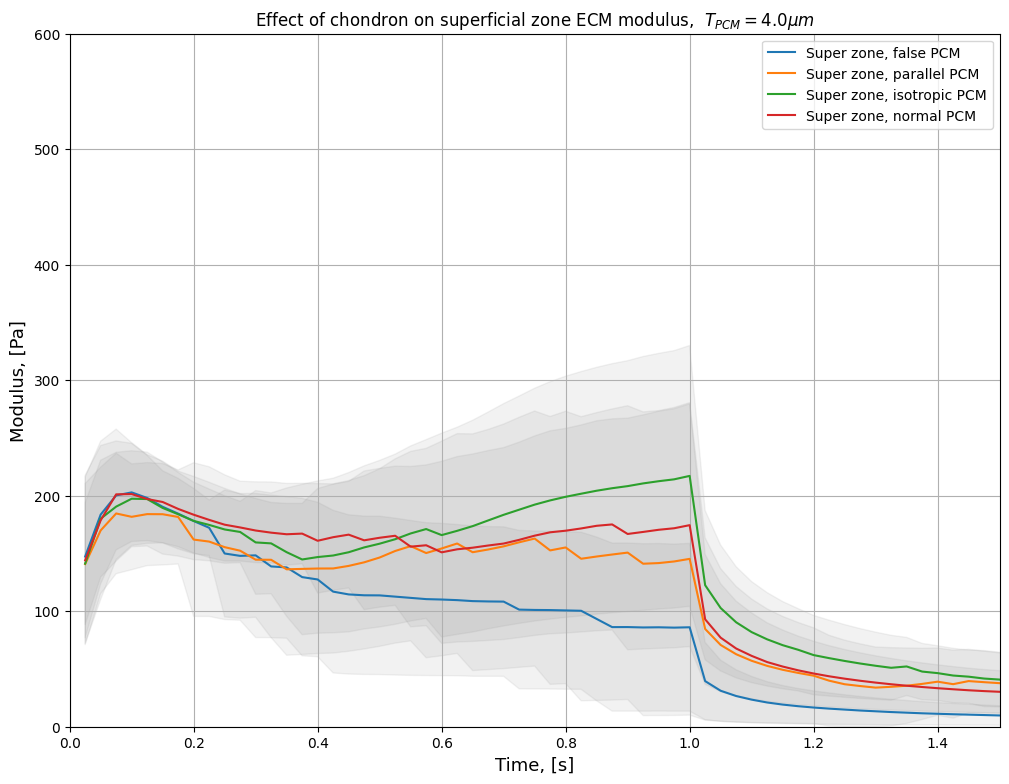

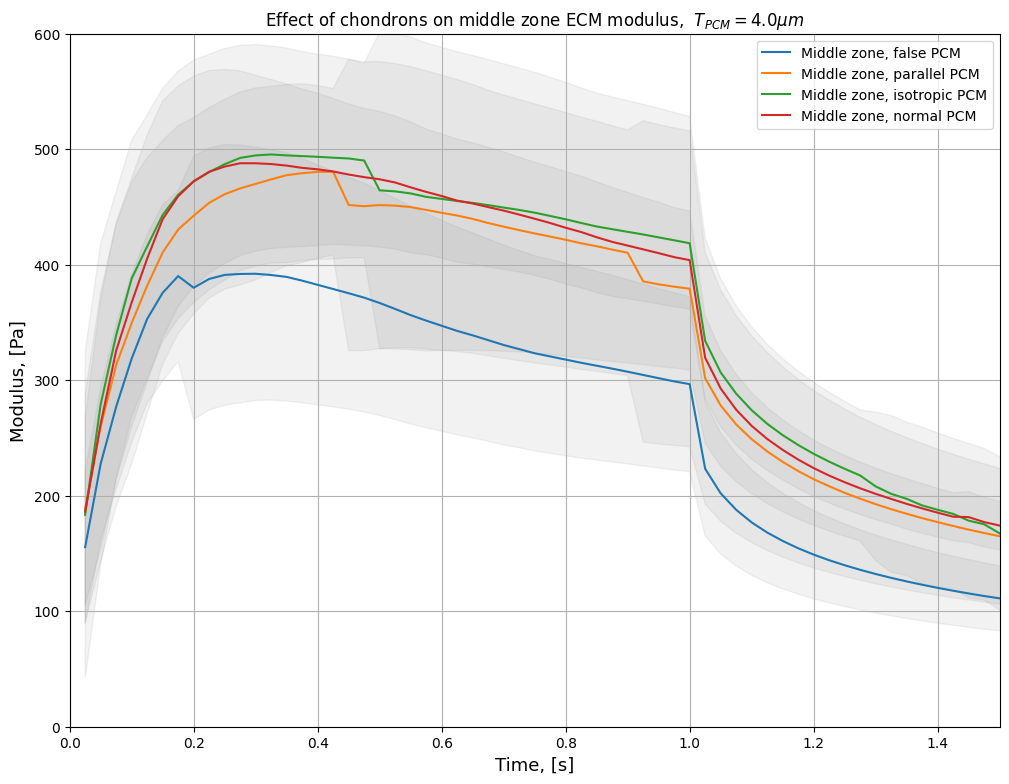

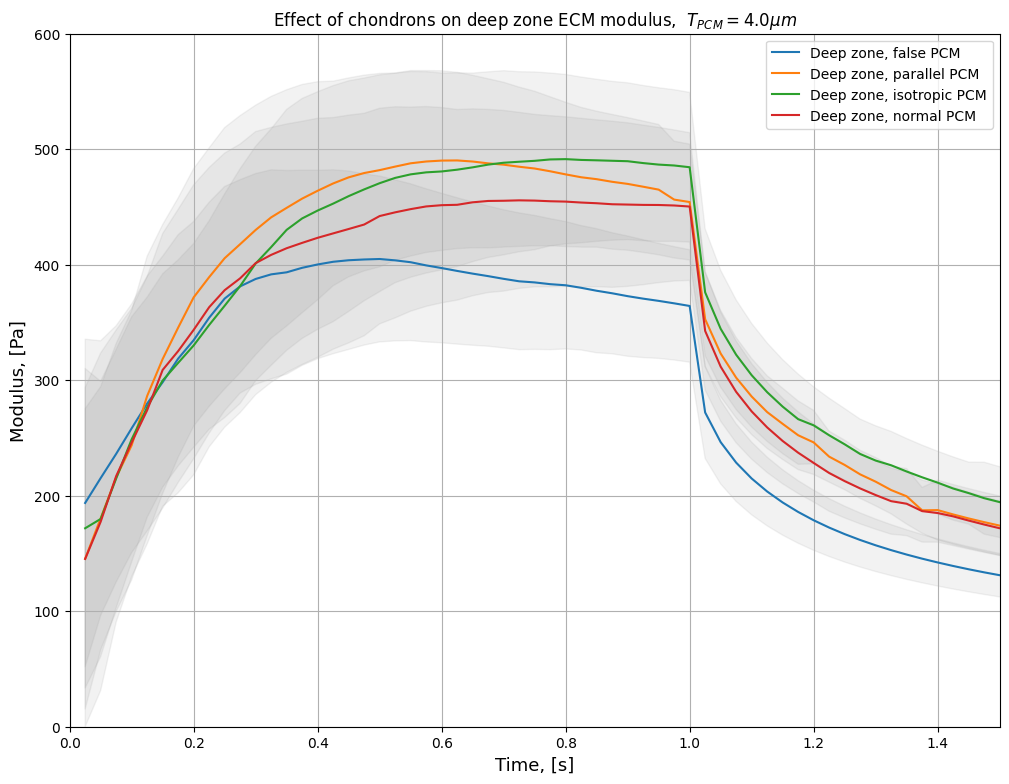

In [54]:
superficial_modulus_data = ['Super zone, false PCM', 'Super zone, parallel PCM', 'Super zone, isotropic PCM', 'Super zone, normal PCM']
middle_modulus_data      = ['Middle zone, false PCM', 'Middle zone, parallel PCM', 'Middle zone, isotropic PCM', 'Middle zone, normal PCM']
deep_modulus_data        = ['Deep zone, false PCM', 'Deep zone, parallel PCM', 'Deep zone, isotropic PCM', 'Deep zone, normal PCM']

super_data_dict = {}
for key in superficial_modulus_data:
    super_data_dict[key] = runs_get_data(total_data[key][1:])

middle_data_dict = {}
for key in middle_modulus_data:
    middle_data_dict[key] = runs_get_data(total_data[key][1:])

deep_data_dict = {}
for key in deep_modulus_data:
    deep_data_dict[key] = runs_get_data(total_data[key][1:])


fig, ax1 = plt.subplots(figsize=(12, 9)) 
for key in superficial_modulus_data:
    df_mean = super_data_dict[key][0]
    df_std = super_data_dict[key][1]
    runs = super_data_dict[key][2]
    modulus = df_mean['Stress'] / df_mean['Strain'] 
    std = df_std['Stress'] / df_mean['Strain'] 
    
    ax1.plot(df_mean['Time'], modulus, label = key)
    ax1.fill_between(df_mean['Time'], [max(this, 0) for this in modulus-std],  modulus+std,  color = 'grey', alpha=0.1) 

plt.title(f'Effect of chondron on superficial zone ECM modulus,  ' r"$T_{PCM}=4.0 \mu m$")
plt.legend()
plt.xlabel('Time, [s]', size = 13)
plt.ylabel('Modulus, [Pa]', size = 13)
ax1.set_ylim(ymin = 0, ymax = 600)
ax1.set_xlim(xmin = 0, xmax=1.5)
plt.grid()
plt.show()   

fig, ax1 = plt.subplots(figsize=(12, 9)) 
for key in middle_modulus_data:
    df_mean = middle_data_dict[key][0]
    df_std = middle_data_dict[key][1]
    runs = middle_data_dict[key][2]
    modulus = df_mean['Stress'] / df_mean['Strain'] 
    std = df_std['Stress'] / df_mean['Strain'] 
    
    ax1.plot(df_mean['Time'], modulus, label = key)
    ax1.fill_between(df_mean['Time'], [max(this, 0) for this in modulus-std],  modulus+std,  color = 'grey', alpha=0.1) 

plt.title(f'Effect of chondrons on middle zone ECM modulus,  ' r"$T_{PCM}=4.0 \mu m$")
plt.legend()
plt.xlabel('Time, [s]', size = 13)
plt.ylabel('Modulus, [Pa]', size = 13)
ax1.set_ylim(ymin = 0, ymax = 600)
ax1.set_xlim(xmin = 0, xmax=1.5)
plt.grid()
plt.show()   

fig, ax1 = plt.subplots(figsize=(12, 9)) 
for key in deep_modulus_data:
    df_mean = deep_data_dict[key][0]
    df_std = deep_data_dict[key][1]
    runs = deep_data_dict[key][2]
    modulus = df_mean['Stress'] / df_mean['Strain'] 
    std = df_std['Stress'] / df_mean['Strain'] 
    
    ax1.plot(df_mean['Time'], modulus, label = key)
    ax1.fill_between(df_mean['Time'], [max(this, 0) for this in modulus-std],  modulus+std,  color = 'grey', alpha=0.1) 

plt.title(f'Effect of chondrons on deep zone ECM modulus,  ' r"$T_{PCM}=4.0 \mu m$")
plt.legend()
plt.xlabel('Time, [s]', size = 13)
plt.ylabel('Modulus, [Pa]', size = 13)
ax1.set_ylim(ymin = 0, ymax = 600)
ax1.set_xlim(xmin = 0, xmax=1.5)
plt.grid()
plt.show()   

In [4]:
noise = np.random.rand(100)
print(noise)
x = np.linspace(0, 100, 100)
plat = 1/100* np.sin()
berg = np.sin()

[0.52287036 0.83984204 0.37978609 0.59648738 0.54769607 0.77379392
 0.40930712 0.19826427 0.83106227 0.86059093 0.95519409 0.29136049
 0.21602547 0.66468054 0.62107262 0.80226083 0.32014906 0.48040458
 0.58402686 0.0145747  0.53576834 0.48583025 0.10806165 0.71832732
 0.69989855 0.02168008 0.92501151 0.06359181 0.21044817 0.1838867
 0.19016346 0.66820139 0.3098224  0.12479673 0.08002956 0.62151928
 0.69279477 0.0526643  0.73498085 0.63039598 0.34184753 0.37901821
 0.37056047 0.89188859 0.74349558 0.27042527 0.21313213 0.31575266
 0.88096833 0.98220821 0.58991717 0.9477305  0.28190527 0.94144234
 0.69819238 0.88510253 0.23603226 0.35216266 0.89857416 0.18392248
 0.57772064 0.56360279 0.06294823 0.40630605 0.62877328 0.56118615
 0.57556875 0.34798085 0.39824059 0.69379756 0.77180261 0.39167428
 0.07964589 0.81076571 0.51963869 0.20454743 0.93884363 0.22592686
 0.16388954 0.55269948 0.23133665 0.09547728 0.40792515 0.53782613
 0.05263409 0.29069829 0.94364713 0.73379316 0.13195638 0.62540

TypeError: sin() takes from 1 to 2 positional arguments but 0 were given